<a href="https://colab.research.google.com/github/mirpouya/Diabeteic-Retinopathy-project---Western-University/blob/main/InceptionV3%20pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lets work with sample data.

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
!unzip ../input/diabetic-retinopathy-detection/sample.zip
!unzip ../input/diabetic-retinopathy-detection/sampleSubmission.csv.zip
! dir sample
!unzip ../input/diabetic-retinopathy-detection/trainLabels.csv.zipyY

Archive:  ../input/diabetic-retinopathy-detection/sample.zip
   creating: sample/
  inflating: sample/10_left.jpeg     
  inflating: sample/10_right.jpeg    
  inflating: sample/13_left.jpeg     
  inflating: sample/13_right.jpeg    
  inflating: sample/15_left.jpeg     
  inflating: sample/15_right.jpeg    
  inflating: sample/16_left.jpeg     
  inflating: sample/16_right.jpeg    
  inflating: sample/17_left.jpeg     
  inflating: sample/17_right.jpeg    
Archive:  ../input/diabetic-retinopathy-detection/sampleSubmission.csv.zip
  inflating: sampleSubmission.csv    
10_left.jpeg   13_left.jpeg   15_left.jpeg   16_left.jpeg   17_left.jpeg
10_right.jpeg  13_right.jpeg  15_right.jpeg  16_right.jpeg  17_right.jpeg
unzip:  cannot find or open ../input/diabetic-retinopathy-detection/trainLabels.csv.zipyY, ../input/diabetic-retinopathy-detection/trainLabels.csv.zipyY.zip or ../input/diabetic-retinopathy-detection/trainLabels.csv.zipyY.ZIP.


# Check Images

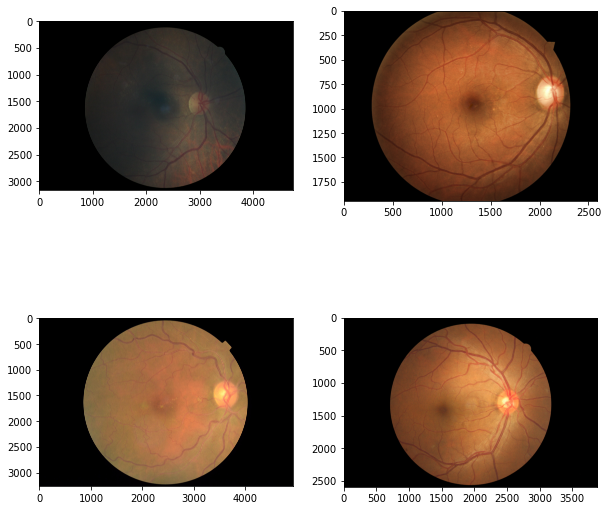

In [ ]:
f, axarr = plt.subplots(2,2, figsize=(10, 10))
axarr[0,0].imshow(Image.open("./sample/10_right.jpeg"))
axarr[0,1].imshow(Image.open("./sample/13_right.jpeg"))
axarr[1,0].imshow(Image.open("./sample/15_right.jpeg"))
axarr[1,1].imshow(Image.open("./sample/17_right.jpeg"))

# Check data distribution

NUM DATA : 5000
NUM CLASSES : 5
CLASS DIST : [3657, 354, 788, 108, 93]


<BarContainer object of 5 artists>

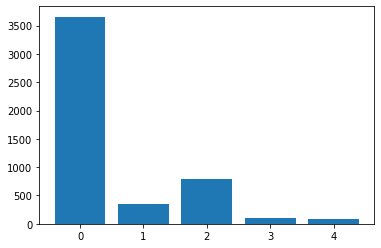

In [ ]:
df = pd.read_csv("../input/diabetic-retinopathy-resized/trainLabels.csv")[:5000]
df['image'] = df['image'].apply(lambda x: "../input/diabetic-retinopathy-resized/resized_train_cropped/resized_train_cropped/" + x + ".jpeg")
df.head()
num_classes = len(np.unique(df['level']))
class_dist = [len(df.loc[df['level'] == x]) for x in range(num_classes)]

print(f"NUM DATA : {len(df)}")
print(f"NUM CLASSES : {num_classes}")
print(f"CLASS DIST : {class_dist}")
plt.bar(np.unique(df['level']), class_dist)

# unlabeled

Lets get the first train file

# Visualization

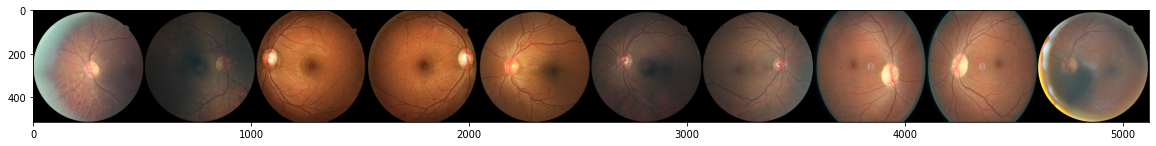

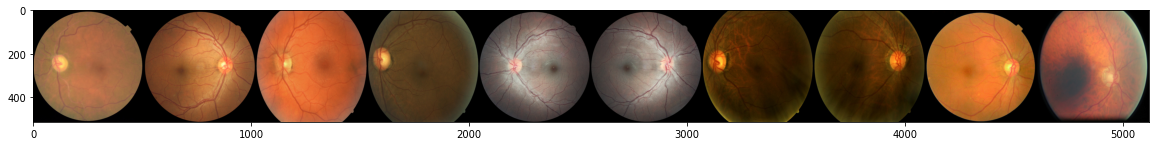

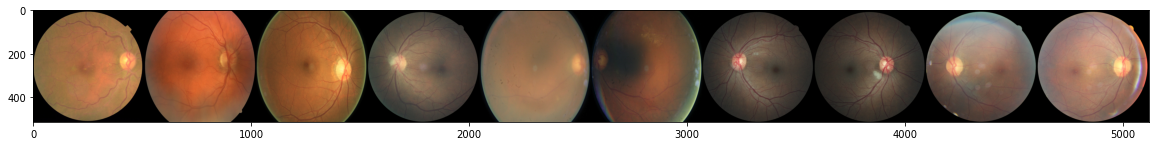

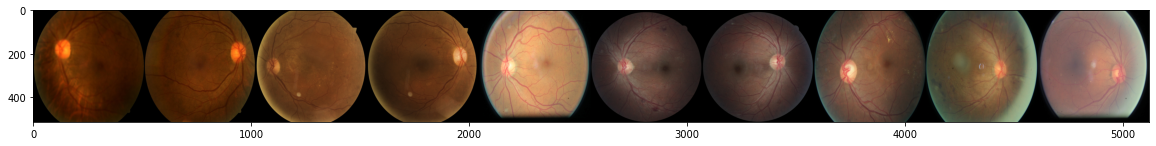

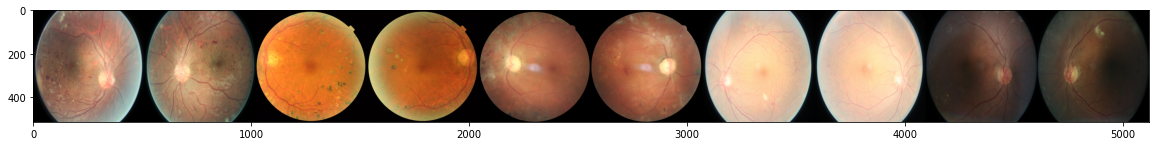

In [ ]:
# visualize
def visualize_image_per_level(level=0):
    level_images = df.loc[df['level'] == level]['image'].values
    IMG_DIR = "../input/diabetic-retinopathy-resized/resized_train/resized_train"
    images = []
    for i in range(10):
        img = Image.open(level_images[i])
        img = img.resize((512, 512))
        images.append(np.array(img))
    images = np.concatenate(images, axis=1)
    plt.figure(figsize=(20, 40))
    plt.imshow(images)

for c in range(num_classes):
    visualize_image_per_level(c)

# Construct dataset

In [ ]:
def examine_files(files, labels):
    confirmed_files = []
    confirmed_labels = []
    for i in range(len(files)):
        if os.path.isfile(files[i]):
            confirmed_files.append(files[i])
            confirmed_labels.append(labels[i])
    return confirmed_files, np.array(confirmed_labels)

# train / val /test split
total_files = df['image'].values
total_labels = df['level'].values

# data scarcity setting
total_files = total_files[:1000]
total_labels = total_labels[:1000]

unlabeled_files = total_files[1000:]
unlabeled_labels = total_labels[1000:]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
remained_idx, test_idx = next(sss.split(total_files, total_labels))
remained_files = total_files[remained_idx]
remained_labels = total_labels[remained_idx]

test_files = total_files[test_idx]
test_labels = total_labels[test_idx]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
train_idx, val_idx = next(sss.split(remained_files, remained_labels))
train_files = remained_files[train_idx]
train_labels = remained_labels[train_idx]

val_files = remained_files[val_idx]
val_labels = remained_labels[val_idx]

train_files, train_labels = examine_files(train_files, train_labels)
val_files, val_labels = examine_files(val_files, val_labels)
test_files, test_labels = examine_files(test_files, test_labels)

train_df = pd.DataFrame(data={'image': train_files, 'level': train_labels})
val_df = pd.DataFrame(data={'image': val_files, 'level': val_labels})
test_df = pd.DataFrame(data={'image': test_files, 'level': test_labels})

print(f"NUM TRAIN / VAL / TEST : {len(train_files)} / {len(val_files)} / {len(test_files)}")
for c in range(num_classes):
    print(f"NUM CLASS {c} TRAIN / VAL / TEST : {len(np.where(train_labels==c)[0])} / {len(np.where(val_labels==c)[0])} / {len(np.where(test_labels==c)[0])}")

NUM TRAIN / VAL / TEST : 639 / 160 / 200
NUM CLASS 0 TRAIN / VAL / TEST : 473 / 118 / 148
NUM CLASS 1 TRAIN / VAL / TEST : 36 / 10 / 12
NUM CLASS 2 TRAIN / VAL / TEST : 95 / 24 / 29
NUM CLASS 3 TRAIN / VAL / TEST : 18 / 4 / 6
NUM CLASS 4 TRAIN / VAL / TEST : 17 / 4 / 5


In [ ]:
import torchvision.transforms as transforms
my_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])

class retinaDataset(Dataset):
    def __init__(self, df,transform=my_transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img = Image.open(self.df.iloc[index].image)

        if(self.transform):
            img = self.transform(img)

        return img, torch.tensor(self.df.iloc[index].level)

In [ ]:
batch_size = 16

train_dataset = retinaDataset(train_df)
val_dataset = retinaDataset(val_df)
test_dataset = retinaDataset(test_df)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Model Build

In [ ]:
from torchvision.models import inception_v3

learning_rate = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = inception_v3(pretrained=True)
model.fc = torch.nn.Linear(in_features=2048, out_features=num_classes, bias=True)
model.aux_logits = False
model = model.to(device=device)

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_criterion = torch.nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [ ]:
device

device(type='cuda')

# Train

In [ ]:
from tqdm import tqdm

def check_accuracy(model, loader):
    model.eval()

    correct_output = 0
    total_output = 0

    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.to(device=device)
            y = y.to(device=device)

            score = model(x)
            _,predictions = score.max(1)

            correct_output += (y==predictions).sum()
            total_output += predictions.shape[0]
    model.train()
    print(f"out of {total_output} , total correct: {correct_output} with an accuracy of {float(correct_output/total_output)*100}")
    return float(correct_output/total_output)*100

num_epochs = 10
best_score = 0
for epoch in range(num_epochs):
    for data, target in tqdm(train_dataloader):
        data = data.to(device=device)
        target = target.to(device=device)

        score = model(data)
        optimizer.zero_grad()

        loss = loss_criterion(score, target)
        loss.backward()

        optimizer.step()

    print(f"for epoch {epoch}, loss : {loss}")
    val_acc = check_accuracy(model, val_dataloader)
    if val_acc > best_score:
        best_score = val_acc
        torch.save(model.state_dict(), "/kaggle/working/best_model.bin")


  0%|          | 0/10 [00:00<?, ?it/s]

for epoch 0, loss : 0.6612900495529175


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


out of 160 , total correct: 118 with an accuracy of 73.7500011920929


  0%|          | 0/10 [00:00<?, ?it/s]

for epoch 1, loss : 0.7927305698394775


100%|██████████| 10/10 [00:03<00:00,  2.92it/s]


out of 160 , total correct: 119 with an accuracy of 74.37500357627869


  0%|          | 0/10 [00:00<?, ?it/s]

for epoch 2, loss : 0.45379477739334106


  0%|          | 0/39 [00:00<?, ?it/s]

out of 160 , total correct: 113 with an accuracy of 70.6250011920929


  0%|          | 0/10 [00:00<?, ?it/s]

for epoch 3, loss : 0.21405690908432007


  0%|          | 0/39 [00:00<?, ?it/s]

out of 160 , total correct: 117 with an accuracy of 73.1249988079071


  0%|          | 0/10 [00:00<?, ?it/s]

for epoch 4, loss : 0.12597069144248962


  0%|          | 0/39 [00:00<?, ?it/s]

out of 160 , total correct: 114 with an accuracy of 71.25000357627869


  0%|          | 0/10 [00:00<?, ?it/s]

for epoch 5, loss : 0.0793556272983551


  0%|          | 0/39 [00:00<?, ?it/s]

out of 160 , total correct: 117 with an accuracy of 73.1249988079071


  0%|          | 0/10 [00:00<?, ?it/s]

for epoch 6, loss : 0.07767710089683533


  0%|          | 0/39 [00:00<?, ?it/s]

out of 160 , total correct: 113 with an accuracy of 70.6250011920929


  0%|          | 0/10 [00:00<?, ?it/s]

for epoch 7, loss : 0.12421678006649017


  0%|          | 0/39 [00:00<?, ?it/s]

out of 160 , total correct: 116 with an accuracy of 72.50000238418579


  0%|          | 0/10 [00:00<?, ?it/s]

for epoch 8, loss : 0.011157622560858727


  0%|          | 0/39 [00:00<?, ?it/s]

out of 160 , total correct: 114 with an accuracy of 71.25000357627869


  0%|          | 0/10 [00:00<?, ?it/s]

for epoch 9, loss : 0.019666295498609543


100%|██████████| 10/10 [00:04<00:00,  2.47it/s]

out of 160 , total correct: 116 with an accuracy of 72.50000238418579


# Evaluate

In [ ]:
model.load_state_dict(torch.load("/kaggle/working/best_model.bin"))

<All keys matched successfully>

In [ ]:
test_preds = []
test_labels = []
with torch.no_grad():
    for data, target in tqdm(test_dataloader):
        data = data.to(device=device)
        target = target.to(device=device)
        logit = model(data)
        pred = torch.softmax(logit, dim=-1)
        pred = pred.cpu().numpy()
        label = target.cpu().numpy()
        test_preds.append(pred)
        test_labels.append(label)

test_preds = np.concatenate(test_preds, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

100%|██████████| 13/13 [00:05<00:00,  2.20it/s]


In [ ]:
from sklearn.metrics import roc_auc_score

def calc_ece(softmax, label, bins=15):
    softmax = torch.FloatTensor(softmax)
    label = torch.FloatTensor(label)
    bin_boundaries = torch.linspace(0, 1, bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    softmax = torch.tensor(softmax)
    labels = torch.tensor(label)

    softmax_max, predictions = torch.max(softmax, 1)
    correctness = predictions.eq(labels)

    ece = torch.zeros(1)
    mce = 0

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = softmax_max.gt(bin_lower.item()) * softmax_max.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean()

        if prop_in_bin.item() > 0.0:
            accuracy_in_bin = correctness[in_bin].float().mean()
            avg_confidence_in_bin = softmax_max[in_bin].mean()
            diff = torch.abs(avg_confidence_in_bin - accuracy_in_bin)
            ece += diff * prop_in_bin
            if diff.item() > mce:
                mce = diff.item()

    return ece.item(), mce

# auroc
for c in range(num_classes):
    if c == 0:
        continue
    c_preds = test_preds[:, c]
    c_labels = np.uint8(test_labels == c)
    test_auc = roc_auc_score(c_labels, c_preds)
    print(f"CLASS {c} AUC : {test_auc}")
ece_score = calc_ece(test_preds, test_labels)
print(f"ECE : {ece_score[0] * 100}, MCE : {ece_score[1] * 100}")

CLASS 1 AUC : 0.5141843971631206
CLASS 2 AUC : 0.6444847751562816
CLASS 3 AUC : 0.7079037800687286
CLASS 4 AUC : 0.7958974358974359
ECE : 8.884317427873611, MCE : 30.00408411026001


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


# OOD Detection

In [ ]:
from tqdm import trange
num_ood = 100
ood_preds = []
with torch.no_grad():
    for i in trange(num_ood):
        img = np.array(Image.open(test_files[i]))
        np.random.shuffle(img)
        img = np.transpose(img, [2, 0, 1])
        img_tensor = torch.FloatTensor(img).to(device).unsqueeze(0)
        logit = model(img_tensor)
        pred = torch.softmax(logit, dim=-1)
        pred = pred.cpu().numpy()
        ood_preds.append(pred)
ood_preds = np.concatenate(ood_preds, axis=0)

100%|██████████| 100/100 [00:06<00:00, 14.60it/s]


In [ ]:
total_labels = [1] * len(test_labels) + [0] * len(ood_preds)
total_preds = np.concatenate([test_preds, ood_preds], axis=0)
msp = np.max(total_preds, axis=-1)
ood_auc = roc_auc_score(total_labels, msp)
print(f"OOD Detection performance (AUC) : {ood_auc}")

OOD Detection performance (AUC) : 0.50845
